In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import copy
import numpy as np
import math
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import itertools
import pandas as pd

from pycmqlib3.utility import dbaccess, dataseries, misc
import pycmqlib3.analytics.data_handler as dh


import sys
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

sys.path.append("C:/dev/pyktrader3/")
sys.path.append("C:/dev/wtpy/")
sys.path.append("C:/dev/akshare/")
sys.path.append("C:/dev/wtdev/")

from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *
from pycmqlib3.analytics.backtest_utils import *

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
mpl.rcParams['figure.figsize'] = (12, 8)

In [4]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))
# display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [4]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'SM', "SF", 'nr', 'SA', 'UR'] # 'ZC', 
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'lh', 'PK', 'CY'] # 'CY',] 

ags_all_mkts = ags_oil_mkts + ags_soft_mkts

eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF', 'TS']

fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts

daily_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2015,12,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2019,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,9,1),  'sn':datetime.date(2017,5,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 10, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2019,4,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 2, 1), 'eg': datetime.date(2019, 4, 2), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 9, 5), 'lu': datetime.date(2020, 10, 1), 'nr': datetime.date(2020,1,1),
    'lh': datetime.date(2021,5,1), 'PF': datetime.date(2021,1,1), 'PK': datetime.date(2021,4,1), }

In [5]:
lead_lag_config = {
    'll_left': -20,
    'll_right': 120,
    'll_spacing': 5,
    'll_sub_win': [(datetime.date(2008, 1, 1), datetime.date(2016, 12, 31)), 
                   (datetime.date(2017, 1, 1), datetime.date(2022, 12, 31)),],
}

ll_keys = ['fullsample'] + ['%s:%s' % (sd.strftime('%Y-%b-%d'), ed.strftime('%Y-%b-%d')) for sd, ed in lead_lag_config['ll_sub_win']]


In [6]:
from bktest.backtest_grid_search import *
tday = datetime.date.today()
roll_name = 'CAL_30b'
df, error_list = load_hist_data(
    start_date=datetime.date(2011,1,1),
    end_date=tday,
    roll_name=roll_name,
    sim_markets=all_markets,
    freq='d'
)

if len(error_list) > 0:
    print(error_list)
    

C:\dev\akshare\akshare\__init__.py:2637: UserWarning: 为了支持更多特性，请将 Pandas 升级到 2.1.0 及以上版本！
  warnings.warn(
C:\dev\akshare\akshare\__init__.py:2642: UserWarning: 为了支持更多特性，请将 Python 升级到 3.9 及以上版本！
  warnings.warn(


continuous contract stopped at ao1103 for start = 2011-01-01, expiry= 2011-01-25
continuous contract stopped at ao1104 for start = 2011-01-01, expiry= 2011-03-02
continuous contract stopped at ao1105 for start = 2011-01-01, expiry= 2011-03-30
continuous contract stopped at ao1106 for start = 2011-01-01, expiry= 2011-05-03
continuous contract stopped at ao1107 for start = 2011-01-01, expiry= 2011-06-02
continuous contract stopped at ao1108 for start = 2011-01-01, expiry= 2011-07-04
continuous contract stopped at ao1109 for start = 2011-01-01, expiry= 2011-08-03
continuous contract stopped at ao1110 for start = 2011-01-01, expiry= 2011-08-26
continuous contract stopped at ao1111 for start = 2011-01-01, expiry= 2011-09-27
continuous contract stopped at ao1112 for start = 2011-01-01, expiry= 2011-11-03
continuous contract stopped at ao1201 for start = 2011-01-01, expiry= 2011-12-01
continuous contract stopped at ao1202 for start = 2011-01-01, expiry= 2011-12-26
continuous contract stopped 

continuous contract stopped at ao2307 for start = 2011-01-01, expiry= 2023-06-01
continuous contract stopped at ao2308 for start = 2011-01-01, expiry= 2023-07-04
continuous contract stopped at ao2309 for start = 2011-01-01, expiry= 2023-08-04
continuous contract stopped at ao2310 for start = 2011-01-01, expiry= 2023-08-25
continuous contract stopped at ao1104 for start = 2011-01-01, expiry= 2011-01-25
continuous contract stopped at ao1105 for start = 2011-01-01, expiry= 2011-03-02
continuous contract stopped at ao1106 for start = 2011-01-01, expiry= 2011-03-30
continuous contract stopped at ao1107 for start = 2011-01-01, expiry= 2011-05-03
continuous contract stopped at ao1108 for start = 2011-01-01, expiry= 2011-06-02
continuous contract stopped at ao1109 for start = 2011-01-01, expiry= 2011-07-04
continuous contract stopped at ao1110 for start = 2011-01-01, expiry= 2011-08-03
continuous contract stopped at ao1111 for start = 2011-01-01, expiry= 2011-08-26
continuous contract stopped 

continuous contract stopped at si1103 for start = 2011-01-01, expiry= 2011-01-24
continuous contract stopped at si1104 for start = 2011-01-01, expiry= 2011-03-03
continuous contract stopped at si1105 for start = 2011-01-01, expiry= 2011-03-30
continuous contract stopped at si1106 for start = 2011-01-01, expiry= 2011-05-03
continuous contract stopped at si1107 for start = 2011-01-01, expiry= 2011-06-01
continuous contract stopped at si1108 for start = 2011-01-01, expiry= 2011-07-01
continuous contract stopped at si1109 for start = 2011-01-01, expiry= 2011-08-03
continuous contract stopped at si1110 for start = 2011-01-01, expiry= 2011-09-01
continuous contract stopped at si1111 for start = 2011-01-01, expiry= 2011-09-26
continuous contract stopped at si1112 for start = 2011-01-01, expiry= 2011-11-02
continuous contract stopped at si1201 for start = 2011-01-01, expiry= 2011-12-02
continuous contract stopped at si1202 for start = 2011-01-01, expiry= 2011-12-23
continuous contract stopped 

continuous contract stopped at si2307 for start = 2011-01-01, expiry= 2023-05-31
continuous contract stopped at si1104 for start = 2011-01-01, expiry= 2011-01-24
continuous contract stopped at si1105 for start = 2011-01-01, expiry= 2011-03-03
continuous contract stopped at si1106 for start = 2011-01-01, expiry= 2011-03-30
continuous contract stopped at si1107 for start = 2011-01-01, expiry= 2011-05-03
continuous contract stopped at si1108 for start = 2011-01-01, expiry= 2011-06-01
continuous contract stopped at si1109 for start = 2011-01-01, expiry= 2011-07-01
continuous contract stopped at si1110 for start = 2011-01-01, expiry= 2011-08-03
continuous contract stopped at si1111 for start = 2011-01-01, expiry= 2011-09-01
continuous contract stopped at si1112 for start = 2011-01-01, expiry= 2011-09-26
continuous contract stopped at si1201 for start = 2011-01-01, expiry= 2011-11-02
continuous contract stopped at si1202 for start = 2011-01-01, expiry= 2011-12-02
continuous contract stopped 

continuous contract stopped at bc1103 for start = 2011-01-01, expiry= 2011-01-25
continuous contract stopped at bc1104 for start = 2011-01-01, expiry= 2011-03-02
continuous contract stopped at bc1105 for start = 2011-01-01, expiry= 2011-03-30
continuous contract stopped at bc1106 for start = 2011-01-01, expiry= 2011-05-03
continuous contract stopped at bc1107 for start = 2011-01-01, expiry= 2011-06-02
continuous contract stopped at bc1108 for start = 2011-01-01, expiry= 2011-07-04
continuous contract stopped at bc1109 for start = 2011-01-01, expiry= 2011-08-03
continuous contract stopped at bc1110 for start = 2011-01-01, expiry= 2011-08-26
continuous contract stopped at bc1111 for start = 2011-01-01, expiry= 2011-09-27
continuous contract stopped at bc1112 for start = 2011-01-01, expiry= 2011-11-03
continuous contract stopped at bc1201 for start = 2011-01-01, expiry= 2011-12-01
continuous contract stopped at bc1202 for start = 2011-01-01, expiry= 2011-12-26
continuous contract stopped 

continuous contract stopped at bc1104 for start = 2011-01-01, expiry= 2011-01-25
continuous contract stopped at bc1105 for start = 2011-01-01, expiry= 2011-03-02
continuous contract stopped at bc1106 for start = 2011-01-01, expiry= 2011-03-30
continuous contract stopped at bc1107 for start = 2011-01-01, expiry= 2011-05-03
continuous contract stopped at bc1108 for start = 2011-01-01, expiry= 2011-06-02
continuous contract stopped at bc1109 for start = 2011-01-01, expiry= 2011-07-04
continuous contract stopped at bc1110 for start = 2011-01-01, expiry= 2011-08-03
continuous contract stopped at bc1111 for start = 2011-01-01, expiry= 2011-08-26
continuous contract stopped at bc1112 for start = 2011-01-01, expiry= 2011-09-27
continuous contract stopped at bc1201 for start = 2011-01-01, expiry= 2011-11-03
continuous contract stopped at bc1202 for start = 2011-01-01, expiry= 2011-12-01
continuous contract stopped at bc1203 for start = 2011-01-01, expiry= 2011-12-26
continuous contract stopped 

continuous contract stopped at eg1905 for start = 2019-04-02, expiry= 2019-04-03
continuous contract stopped at eb2003 for start = 2020-02-01, expiry= 2020-02-27
continuous contract stopped at lu2012 for start = 2020-10-01, expiry= 2020-10-26
continuous contract stopped at pg2010 for start = 2020-09-05, expiry= 2020-09-07
continuous contract stopped at IF2406 for start = 2024-05-18, expiry= 2024-06-21
continuous contract stopped at IF2407 for start = 2024-05-18, expiry= 2024-07-19
continuous contract stopped at IF2408 for start = 2024-05-18, expiry= 2024-08-16
continuous contract stopped at IF2409 for start = 2024-05-18, expiry= 2024-09-20
continuous contract stopped at IF2410 for start = 2024-05-18, expiry= 2024-10-18
continuous contract stopped at IF2411 for start = 2024-05-18, expiry= 2024-11-15
continuous contract stopped at IF2412 for start = 2024-05-18, expiry= 2024-12-20
continuous contract stopped at IF2501 for start = 2024-05-18, expiry= 2025-01-17
continuous contract stopped 

In [ ]:
# field_list = ['contract', 'open', 'high', 'low', 'close', 'volume', 'openInterest', 'diff_oi', 'expiry', 'mth', 'shift']

# start_date = datetime.date(2010,1,1)
# end_date = datetime.date(2023,1,20)
# shift_mode = 1
# roll_name = 'hot'
# roll_file_loc = "C:/dev/wtdev/config/"
# sim_markets = all_markets
# nb_cont = 2
# freq='d'

# data_df = pd.DataFrame()

# for prodcode in sim_markets:
#     for nb in range(nb_cont):
#         print("loading product = %s nb = %s" % (prodcode, nb))
#         xdf = dataseries.nearby(prodcode,
#                                   nb+1,
#                                   start_date=start_date, 
#                                   end_date=end_date, 
#                                   shift_mode=shift_mode,
#                                   freq=freq, 
#                                   roll_name=roll_name, 
#                                   config_loc=roll_file_loc)
#         xdf['expiry'] = xdf['contract'].map(misc.contract_expiry)
#         xdf['contmth'] = xdf['contract'].map(misc.inst2contmth)
#         xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100) 
#         xdf['product'] = prodcode
#         xdf['code'] = f'c{nb+1}'
#         data_df = data_df.append(xdf)

# df = pd.pivot_table(data_df.reset_index(), index='date', columns = ['product', 'code'], values = field_list, aggfunc = 'last')
# df = df.reorder_levels([1, 2, 0], axis=1).sort_index(axis=1)
# df.columns.rename(['product', 'code', 'field',], inplace = True)
# df.index = pd.to_datetime(df.index)

# print(df.tail(20))


In [9]:
#ind_metal_mkts
# scenarios = [('tscarry', 'ryield', 0.33, 1, 1, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 60, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 100, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 240, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('xscarry', 'ryieldsma', 0.0, 1, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'ryieldsma', 0.0, 1, 50, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmom', 0.0, 110, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmom', 0.0, 140, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmomsma', 0.0, 90, 20, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmomsma', 0.0, 230, 20, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 20, 50, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 30, 120, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'mixmom', 0.03, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'mixmom', 0.03, 20, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 20, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 60, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'macdnma', 0.03, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
#              ('tsmom', 'macdnma', 0.03, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
#              ('tsmom', 'macdnma', 0.03, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
#              #('xsmom', 'mom', 0.0, 130, 1, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'mom', 0.0, 230, 1, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 60, 80, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 10, 80, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 40, 20, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'macdnma', 0.0, 16, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
#              #('xsmom', 'macdnma', 0.0, 40, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
#              #('xsmom', 'macdnma', 0.0, 56, 280, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
#             ] 

scenarios_test = [
    ('tscarry', 'ryieldnmb', 0.6, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 1.5, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 1.5, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.0, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

    ('tscarry', 'basmomnma', 0.5, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.42, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.35, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.35, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 2.0, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 1.8, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
    ('xscarry-rank', 'ryieldnma', 1.4, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'ryieldnma', 2.0, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'ryieldnma', 2.0, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

    ('xscarry-rank', 'basmomnma', 2.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 3.0, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 3.0, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

    ('tsmom', 'hlbrk', 0.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.5, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.5, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.5, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.5, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
    ('tsmom', 'macdnma', 0.22, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
    ('tsmom', 'macdnma', 0.20, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
    ('tsmom', 'macdnma', 0.18, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
    ('xsmom-rank', 'hlbrk', 0.375, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.375, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.375, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.375, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.375, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.6, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.6, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.6, 240, 60, 1, (None, {}, ''), [0.0], 0.2),    
    ('custom', 'hc_rb_diff', 0.23, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    
#     ('custom', 'hc_rb_diff', 0.0767, 30, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('custom', 'hc_rb_diff', 0.0767, 40, 122, 1, (None, {}, ''), [0.0, 0.0]),
]

#commod_mkts
scenarios_elite = [ \
        ('tscarry', 'ryieldnmb', 2.0, 1, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 1.0, 100, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 1.0, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),
#        #('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), 
#        #('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'ryieldnma',1.9, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry-rank_cutoff', 'ryieldnma', 2.1, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2),             
#        #'xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        #'xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'basmomnma', 2.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'basmomnma', 2.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        #('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]),
#        ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'hlbrk', 1.1, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 0.9, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 0.9, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('tsmom', 'macdnma', 0.22, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
        ('tsmom', 'macdnma', 0.20, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
#        ('tsmom', 'macdnma', 0.3, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
#        #('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom-rank_cutoff', 'hlbrk', 0.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom-rank_cutoff', 'hlbrk', 0.75, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom-rank_cutoff', 'hlbrk', 0.75, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#        ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2),
#        ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom-rank_cutoff', 'momnma', 0.75, 130, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 240, 90, 5, (None, {}, ''), [0.0], 0.2),
        #('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2),
        #('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2),
        
        ('custom', 'hc_rb_diff', 0.23, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
                   
#         ('custom', 'hc_rb_diff', 0.0767, 30, 122, 1, (None, {}, ''), [0.0, 0.0]),
#         ('custom', 'hc_rb_diff', 0.0767, 40, 122, 1, (None, {}, ''), [0.0, 0.0]),
]


#commod_mkts
scenarios_all = [ \
             ('tscarry', 'ryieldnmb', 2.8, 1, 120, 1, (None, {}, ''), [0.0, 0.0]), \
             ('tscarry', 'basmomnma', 0.7, 100, 120, 1, (None, {}, ''), [0.0, 0.0]), \
             ('tscarry', 'basmomnma', 0.5, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),\
             #('tscarry', 'basmomnma', 0.2, 230, 120, 1, (None, {}, ''), [0.0, 0.0]),\
             ('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xscarry', 'ryieldsma', 0.15, 1, 110, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldnma',1.5, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldnma', 1.8, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xscarry', 'ryieldnma', 0.2, 1, 210, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]), \
             ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]), \
             ('tsmom', 'hlbrk', 2.0, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'hlbrk', 1.5, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'hlbrk', 1.2, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('tsmom', 'momxma', 0.2, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'momxma', 0.15, 40, 80, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.375, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.3, 30, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.3, 220, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'rsixea', 0.25, 30, 40, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'rsixea', 0.25, 30, 110, 5, (misc.sign, {}, 'sign'), [0.0]), \
             ('tsmom', 'macdnma', 0.4, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
             ('tsmom', 'macdnma', 0.3, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
             ('tsmom', 'macdnma', 0.3, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
             #('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.2, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.2, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momnma', 1.0, 130, 90, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momnma', 1.0, 240, 90, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 70, 60, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 100, 80, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 90, 10, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'macdnma', 0.1, 8, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 12.5], 0.2), \
             #('xsmom', 'macdnma', 0.1, 16, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
             #('xsmom', 'macdnma', 0.1, 32, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 3.125], 0.2), \
             #('xsmom', 'macdnma', 0.1, 64, 100, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 1.56], 0.2), \
            ]

scenarios_mixed = [('tscarry', 'ryield', 3.0, 1, 1, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 60, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 100, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 240, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 #('xscarry', 'ryieldsma', 1.0, 1, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'ryieldsma', 1.0, 1, 50, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmom', 1.0, 110, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmom', 1.0, 140, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmomsma', 1.0, 90, 20, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmomsma', 1.0, 230, 20, 5, (None, {}, ''), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 20, 50, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 30, 120, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'mixmom', 1.0, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'mixmom', 1.0, 20, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 20, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 60, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'macdnma', 1.0, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
                 ('tsmom', 'macdnma', 1.0, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
                 ('tsmom', 'macdnma', 1.0, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
                 #('xsmom', 'mom', 1.0, 130, 1, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'mom', 1.0, 230, 1, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 60, 80, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 10, 80, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 40, 20, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'macdnma', 1.0, 16, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
                 #('xsmom', 'macdnma', 1.0, 40, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
                 #('xsmom', 'macdnma', 1.0, 56, 280, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), 
] 


scenarios_intraday = [ \
             #('xsfact', 'trdstrsma', 1.0, 1, 10, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xsfact', 'trdstrsma', 1.0, 1, 15, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'trdstrsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'trdstrsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 5, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 10, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 20, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
            ]

# scenarios_test = [
#     ('tsmom', 'macd', 1.0, 8, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 16, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 32, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 64, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 8, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 16, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 24, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 64, 8, 1, (None, {}, ''), [4.0, 3.0]),
# ]




In [9]:
# bad
#     ('tsmom', 'basmomelv', 1.0, 230, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tsmom', 'basmomelv', 1.0, 110, 40, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tsmom', 'basmomelv', 1.0, 20, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('xsmom-rank', 'momqtl', 1.0, 60, 122, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momqtl', 1.0, 120, 122, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momqtl', 1.0, 240, 122, 1, (None, {}, ''), [0.0], 0.2),

# good
#     ('tsmom', 'macd', 1.0, 4, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 8, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 16, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 32, 1, 10, (None, {}, ''), [4, 35], 0.2),
    
# ?? 
# vs ryieldqtl
#     ('tscarry', 'ryieldelv', 1.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldelv', 1.0, 1, 61, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldelv', 1.0, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),
# vs other basmomqtl
#     ('tscarry', 'basmomqtl', 1.0, 20, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.0, 70, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.0, 120, 244, 1, (None, {}, ''), [0.0, 0.0]),

# rank or demedian
#     ('tscarry', 'ryieldnmb', 1.0, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

#     ('tscarry', 'basmomnma', 0.5, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.42, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.35, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.35, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 2.0, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.8, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

#     ('xscarry-rank', 'basmomnma', 2.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'basmomnma', 2.0, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'basmomnma', 2.0, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

#     ('tsmom', 'hlbrk', 0.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
#     ('tsmom', 'macdnma', 0.22, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
#     ('tsmom', 'macdnma', 0.20, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
#     ('tsmom', 'macdnma', 0.18, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
#     ('xsmom-rank', 'hlbrk', 0.375, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 240, 60, 1, (None, {}, ''), [0.0], 0.2),


In [10]:
scen_names = {}
scen_metrics = {}
scen_stats = {}
bt_empirics = {}
holdings = {}

run name: tscarry-ryieldnmb-1-120-1:



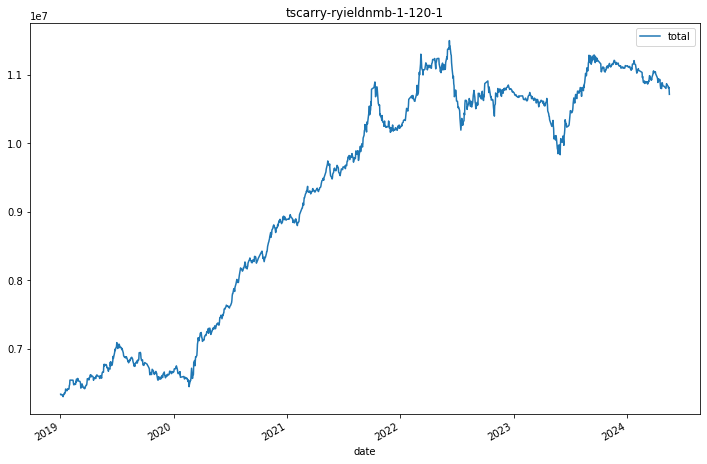

       sharpe       std  sortino
tenor                           
all      1.54  33598.86     2.23
6m      -2.13  27544.74    -3.30
1y       0.95  44968.60     1.53
2y      -0.28  49496.02    -0.44
3y       0.43  50939.92     0.67
4y       1.18  46799.25     1.80
5y       1.17  44814.88     1.80
6y       1.19  43074.69     1.82
7y       1.21  40599.21     1.81
8y       1.36  39121.44     2.05
9y       1.31  38247.43     1.97
10y      1.34  37005.79     2.00
11y      1.48  35939.97     2.20
run name: tscarry-basmomnma-100-120-1:



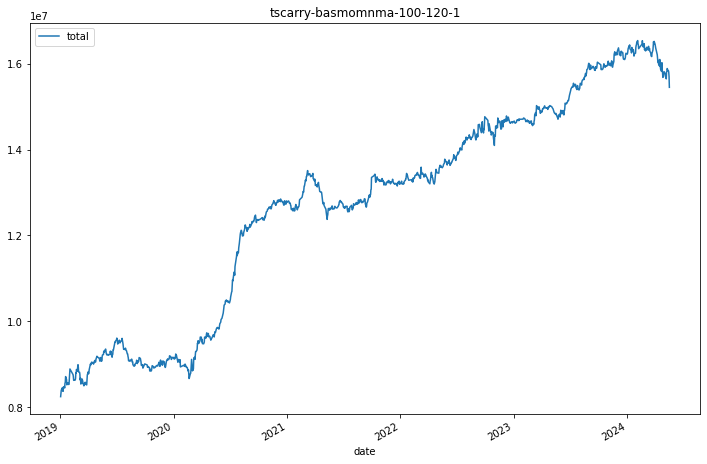

       sharpe       std  sortino
tenor                           
all      1.55  48143.11     2.25
6m      -0.83  74456.04    -1.40
1y       0.64  62391.22     0.98
2y       0.97  62218.29     1.53
3y       1.03  58630.57     1.66
4y       1.59  57756.26     2.56
5y       1.41  57028.16     2.21
6y       1.40  57132.72     2.17
7y       1.34  54330.76     2.05
8y       1.48  52901.91     2.29
9y       1.36  54446.84     2.08
10y      1.32  53157.27     2.02
11y      1.49  51907.64     2.28
run name: tscarry-basmomnma-170-120-1:



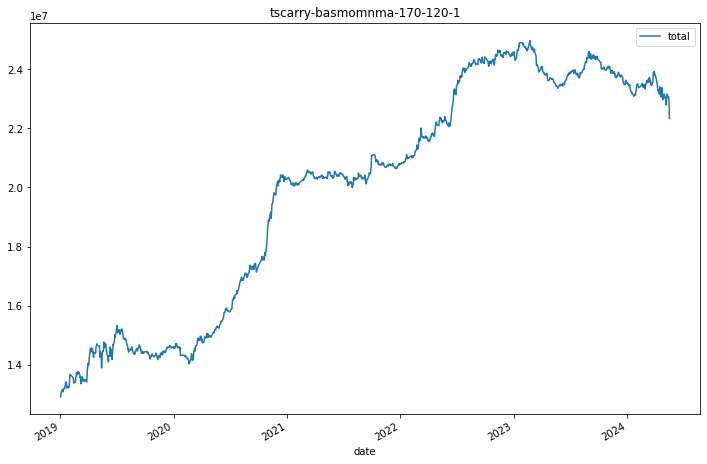

       sharpe        std  sortino
tenor                            
all      1.57   68293.84     2.32
6m      -1.93  104407.21    -2.53
1y      -0.87   84917.93    -1.12
2y       0.06   80147.93     0.09
3y       0.51   76460.15     0.77
4y       1.52   75543.57     2.35
5y       1.34   76909.18     2.09
6y       1.40   78527.23     2.15
7y       1.34   74747.73     2.03
8y       1.58   73883.81     2.43
9y       1.49   78576.27     2.34
10y      1.50   76163.14     2.35
11y      1.68   74336.12     2.62
run name: xscarry-rank_cutoff-ryieldnma-1-20-1:



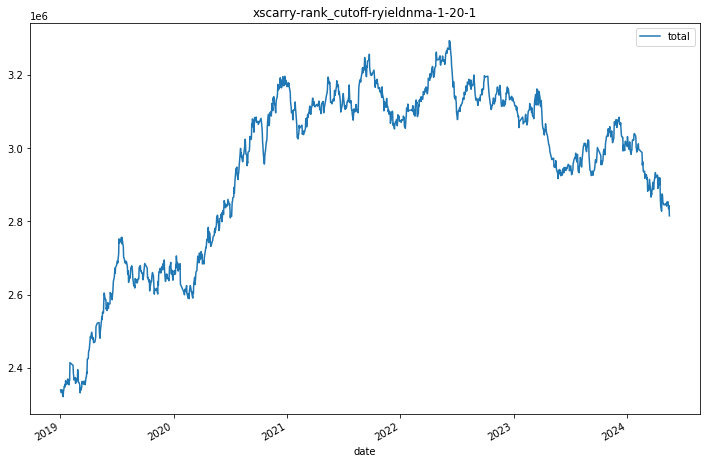

       sharpe       std  sortino
tenor                           
all      1.12  12135.73     1.74
6m      -1.83  14298.23    -2.71
1y      -0.65  13121.91    -0.94
2y      -1.06  12907.69    -1.46
3y      -0.62  13011.76    -0.88
4y       0.05  13501.34     0.07
5y       0.27  13662.22     0.40
6y       0.56  13592.04     0.86
7y       0.68  13335.82     1.04
8y       0.71  13300.34     1.10
9y       0.83  13155.61     1.30
10y      0.84  13014.93     1.32
11y      0.99  12905.51     1.57
run name: xscarry-rank_cutoff-ryieldnma-1-110-1:



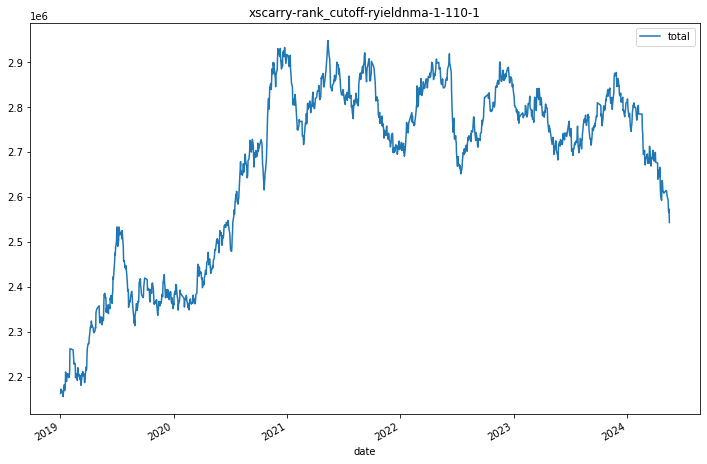

       sharpe       std  sortino
tenor                           
all      1.04  12157.26     1.55
6m      -2.50  13847.49    -3.63
1y      -0.85  13027.45    -1.27
2y      -0.76  13075.28    -1.06
3y      -0.62  13360.90    -0.88
4y       0.07  13929.63     0.11
5y       0.21  13826.14     0.32
6y       0.50  13604.49     0.77
7y       0.59  13358.52     0.90
8y       0.72  13220.75     1.11
9y       0.71  13115.09     1.10
10y      0.72  12897.12     1.12
11y      0.93  12833.97     1.41
run name: xscarry-rank_cutoff-basmomnma-80-120-5:



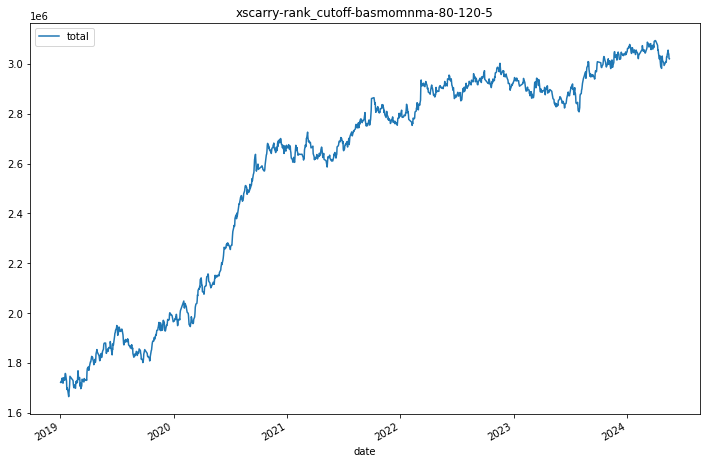

       sharpe       std  sortino
tenor                           
all      1.42  10928.29     2.22
6m       0.38  11905.99     0.67
1y       0.93  12289.86     1.53
2y       0.32  11795.28     0.50
3y       0.71  11976.34     1.13
4y       1.16  12154.86     1.87
5y       1.25  12177.74     2.00
6y       1.24  12464.34     1.98
7y       1.20  12172.75     1.91
8y       1.18  11958.02     1.89
9y       1.17  11813.84     1.85
10y      1.20  11574.50     1.91
11y      1.36  11392.49     2.15
run name: xscarry-rank_cutoff-basmomnma-150-120-5:



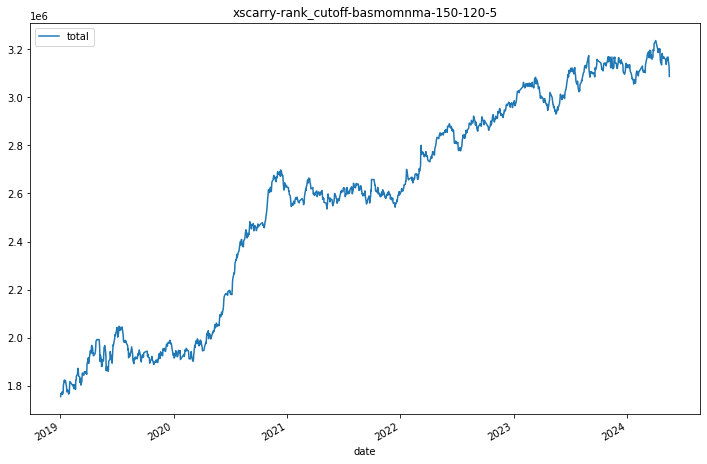

       sharpe       std  sortino
tenor                           
all      1.45  11158.11     2.24
6m      -0.30  14335.29    -0.51
1y       0.64  14205.12     0.98
2y       0.61  12575.38     0.94
3y       0.86  12555.35     1.37
4y       1.33  12595.04     2.13
5y       1.20  12853.63     1.90
6y       1.22  13094.14     1.91
7y       1.15  12619.41     1.78
8y       1.22  12483.29     1.92
9y       1.25  12209.27     1.97
10y      1.26  11791.33     1.97
11y      1.41  11528.91     2.19
run name: tsmom-hlbrk-10-1-10:



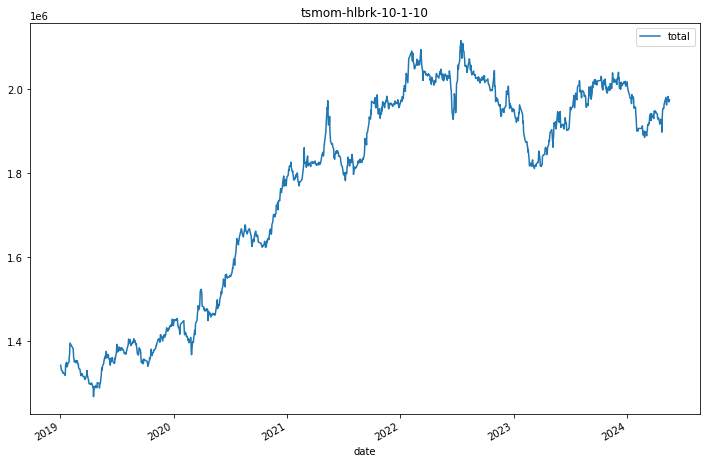

       sharpe       std  sortino
tenor                           
all      1.16   8179.14     1.69
6m      -0.91   9349.04    -1.34
1y       0.33  10108.98     0.51
2y      -0.15  10884.04    -0.21
3y       0.12  10583.42     0.17
4y       0.79  10329.31     1.12
5y       0.84   9841.12     1.19
6y       0.83   9433.54     1.19
7y       0.82   9209.20     1.18
8y       0.90   9093.54     1.31
9y       0.92   9007.94     1.34
10y      0.96   8761.54     1.39
11y      1.09   8570.09     1.58
run name: tsmom-hlbrk-30-1-10:



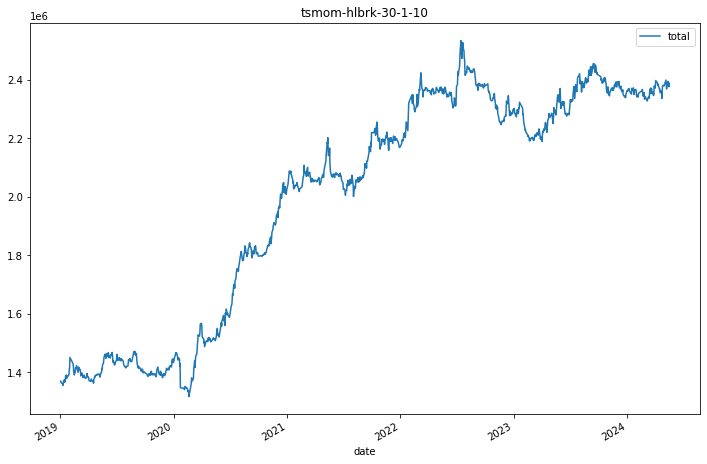

       sharpe       std  sortino
tenor                           
all      1.12  10246.36     1.60
6m       0.20   9741.37     0.34
1y       0.48  12438.84     0.74
2y       0.08  12636.76     0.12
3y       0.41  13017.31     0.61
4y       1.10  12810.08     1.67
5y       1.02  12324.58     1.45
6y       0.97  11707.34     1.39
7y       0.90  11407.64     1.30
8y       0.89  11337.37     1.31
9y       0.96  11248.31     1.39
10y      1.00  10946.55     1.45
11y      1.10  10682.28     1.59
run name: tsmom-hlbrk-240-1-10:



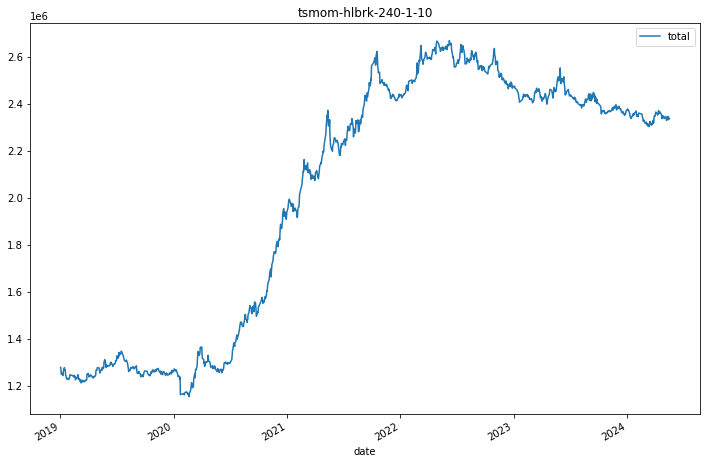

       sharpe       std  sortino
tenor                           
all      1.11  10124.77     1.53
6m      -0.85   7140.35    -1.59
1y      -0.83   9550.90    -1.17
2y      -0.94  10254.30    -1.34
3y       0.06  12152.60     0.08
4y       1.32  12991.41     1.99
5y       1.11  12418.96     1.60
6y       1.07  11686.21     1.53
7y       0.95  11152.98     1.35
8y       1.06  11161.73     1.53
9y       1.00  11288.54     1.45
10y      1.04  11157.52     1.49
11y      1.17  10903.35     1.69
run name: tsmom-macdnma-8-160-5:



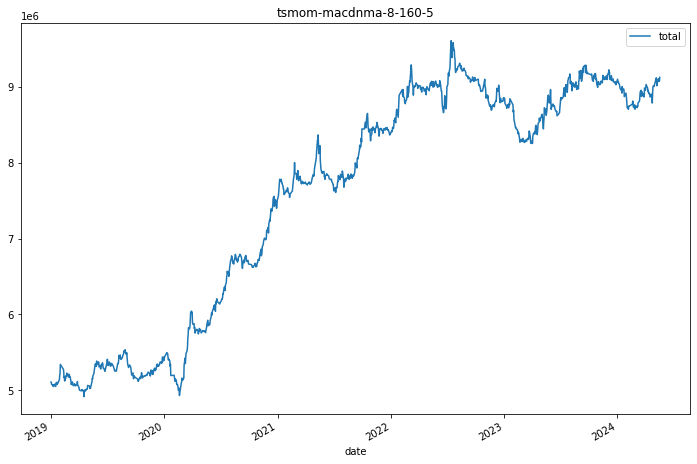

       sharpe       std  sortino
tenor                           
all      1.17  37535.55     1.68
6m      -0.08  39977.95    -0.14
1y       0.56  47706.87     0.90
2y       0.07  49581.42     0.11
3y       0.43  49680.87     0.65
4y       1.11  48500.65     1.63
5y       1.10  46341.56     1.62
6y       1.00  44077.73     1.48
7y       0.93  42896.30     1.38
8y       0.97  42300.49     1.45
9y       1.02  42131.17     1.53
10y      1.03  40884.53     1.53
11y      1.09  39696.12     1.60
run name: tsmom-macdnma-16-160-5:



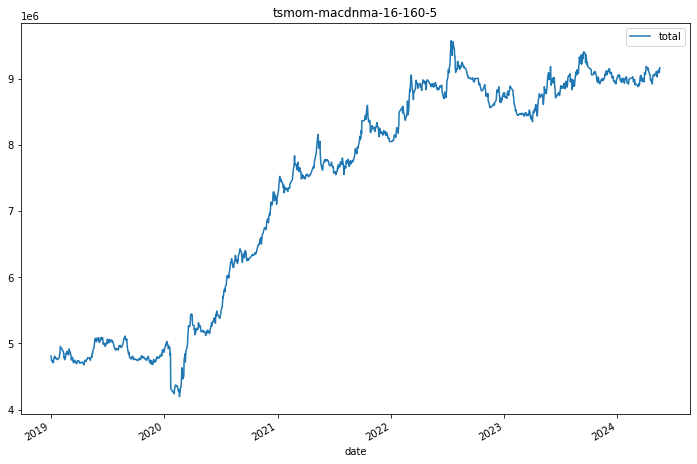

       sharpe       std  sortino
tenor                           
all      1.06  41543.07     1.42
6m       0.57  37306.69     1.09
1y       0.42  51247.05     0.66
2y       0.17  50700.10     0.25
3y       0.49  52736.40     0.74
4y       1.26  51740.66     1.87
5y       1.06  52347.19     1.40
6y       0.96  49447.13     1.28
7y       0.84  47899.96     1.14
8y       0.86  47050.05     1.17
9y       0.94  46865.49     1.30
10y      0.97  45392.10     1.34
11y      1.02  43937.35     1.39
run name: xsmom-rank_cutoff-hlbrk-20-1-10:



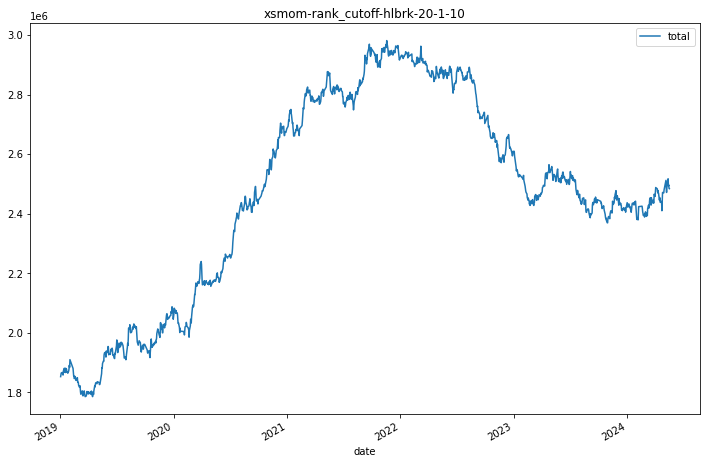

       sharpe       std  sortino
tenor                           
all      1.17  10293.40     1.87
6m       0.43  12730.37     0.83
1y      -0.18  11890.26    -0.32
2y      -1.08  11703.09    -1.65
3y      -0.68  11899.71    -1.07
4y       0.42  12069.46     0.66
5y       0.64  12132.33     1.05
6y       0.58  11788.34     0.95
7y       0.62  11653.73     1.03
8y       0.55  11461.37     0.91
9y       0.69  11181.28     1.14
10y      0.84  11057.95     1.38
11y      1.04  10871.55     1.70
run name: xsmom-rank_cutoff-hlbrk-120-1-10:



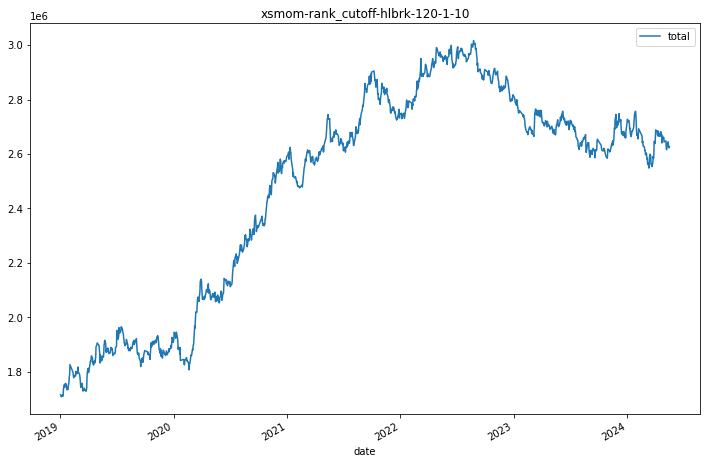

       sharpe       std  sortino
tenor                           
all      1.10  11923.30     1.73
6m      -0.18  16113.90    -0.36
1y      -0.20  14193.42    -0.34
2y      -0.81  13072.27    -1.27
3y      -0.16  13719.05    -0.26
4y       0.65  13982.47     1.05
5y       0.72  13933.46     1.18
6y       0.79  13846.20     1.30
7y       0.65  13524.13     1.05
8y       0.66  13244.77     1.06
9y       0.68  12893.85     1.10
10y      0.79  12681.79     1.27
11y      0.99  12490.79     1.59
run name: xsmom-rank_cutoff-hlbrk-240-1-10:



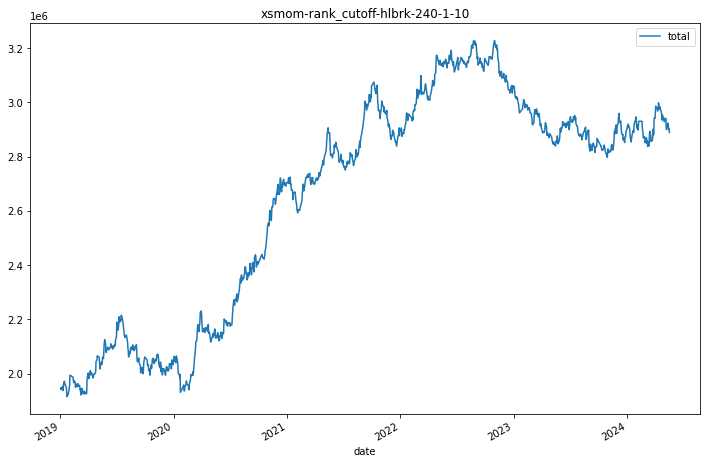

       sharpe       std  sortino
tenor                           
all      1.25  12011.75     1.93
6m       0.47  15110.42     0.90
1y       0.23  13906.16     0.38
2y      -0.61  12827.25    -0.94
3y      -0.00  13644.53    -0.00
4y       0.87  13947.54     1.41
5y       0.78  14069.69     1.24
6y       0.91  13879.71     1.46
7y       0.88  13498.21     1.40
8y       0.90  13207.40     1.44
9y       0.85  12955.39     1.34
10y      0.92  12706.76     1.44
11y      1.14  12491.75     1.78
run name: xsmom-rank_cutoff-momnma-130-90-5:



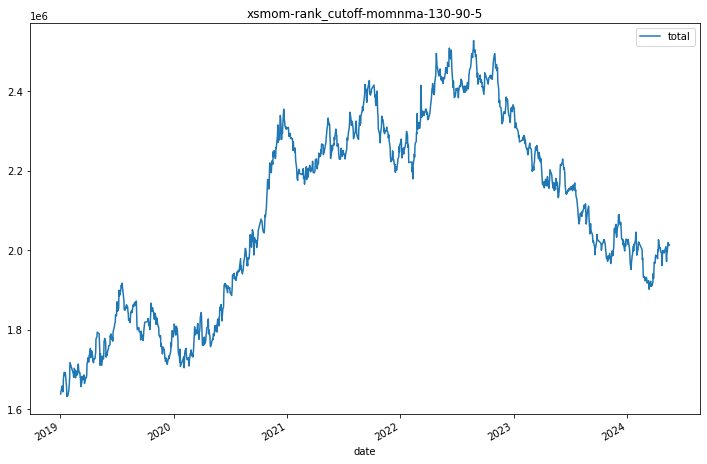

       sharpe       std  sortino
tenor                           
all      0.86  12081.19     1.33
6m       0.15  13760.91     0.25
1y      -0.70  12907.79    -1.12
2y      -1.04  12772.49    -1.65
3y      -0.48  14032.00    -0.76
4y       0.24  14332.68     0.39
5y       0.26  14211.81     0.43
6y       0.35  14005.87     0.56
7y       0.43  13604.87     0.69
8y       0.52  13377.51     0.83
9y       0.57  13161.50     0.91
10y      0.60  12855.22     0.95
11y      0.81  12628.02     1.27
run name: xsmom-momnma-240-90-5:



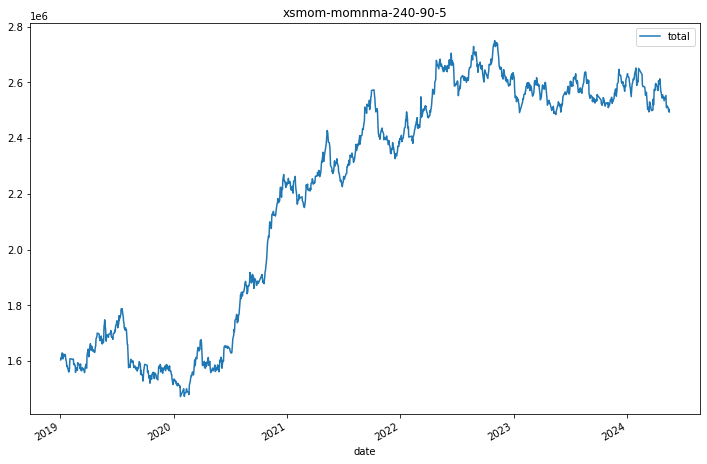

       sharpe       std  sortino
tenor                           
all      1.10  12122.27     1.68
6m      -0.36  14904.05    -0.64
1y       0.03  13419.92     0.05
2y      -0.38  13588.23    -0.60
3y       0.16  14156.52     0.26
4y       1.05  14280.08     1.73
5y       0.75  14211.31     1.20
6y       0.79  14021.62     1.26
7y       0.89  13690.38     1.42
8y       0.97  13345.84     1.54
9y       0.85  13137.69     1.34
10y      0.83  12828.96     1.29
11y      1.00  12476.90     1.55
run name: custom-hc_rb_diff-20-122-1:



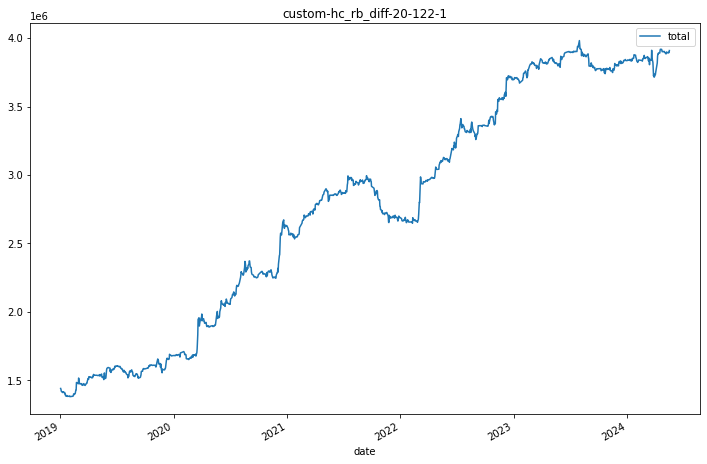

       sharpe       std  sortino
tenor                           
all      1.41  17982.43     2.28
6m       1.20  17495.14     1.59
1y       0.37  15464.14     0.47
2y       1.56  16590.05     2.30
3y       1.36  17384.03     2.19
4y       1.84  17476.77     2.96
5y       1.80  17054.61     2.84
6y       1.69  16773.27     2.62
7y       1.40  16580.45     2.15
8y       1.46  16840.75     2.23
9y       1.48  18833.77     2.50
10y      1.41  17982.43     2.28
11y      1.41  17982.43     2.28


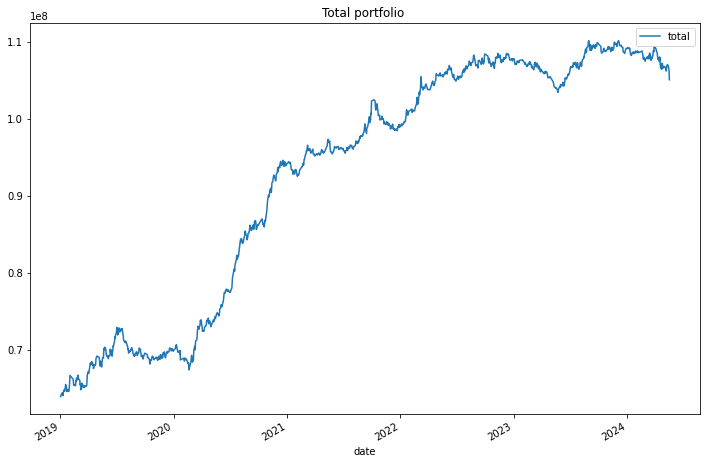

total portfolio stats:

asset = rb, turnover per day = 0.1233521895093577, pnl per trade = 0.00308282566770479
asset = hc, turnover per day = 0.11651442116134542, pnl per trade = 0.005395079031878653
asset = i, turnover per day = 0.07250559633001594, pnl per trade = 0.0004163219849625244
asset = j, turnover per day = 0.13582554094967306, pnl per trade = 0.004070762525333451
asset = jm, turnover per day = 0.10792371346991972, pnl per trade = 0.0006210756319595879
asset = ru, turnover per day = 0.10888833093603956, pnl per trade = 0.01452254514133997
asset = FG, turnover per day = 0.10642842131876644, pnl per trade = 0.0005084119739600563
asset = cu, turnover per day = 0.1917419799841206, pnl per trade = 0.2542881153243618
asset = al, turnover per day = 0.16067289729357223, pnl per trade = 0.04610998516428035
asset = zn, turnover per day = 0.2226127148541577, pnl per trade = 0.09585037514465775
asset = sn, turnover per day = 0.29619299979005953, pnl per trade = 17.72674548145357
asset = 

In [11]:
file_folder = "C:\\dev\\data\\data_cache\\"

start_date = datetime.date(2011,1,1)
end_date = tday

scenario_map = {
    'test': scenarios_test,
    'elite': scenarios_elite,
    'all': scenarios_all,
}

shift_mode = 1
rev_char = '!'
exec_mode = 'open'
cost_ratio = 0.5
total_risk = 4600.0*34
asset_scaling = False

std_win = 20
pnl_tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y', '10y', '11y']

# product_list = product_grouping_partial['ind'] + product_grouping_partial['petro'] + product_grouping_partial['ags']
# product_list = product_grouping_complete['ind'] + product_grouping_complete['petro'] + product_grouping_complete['ags']

product_list = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'cu', 'al', 'zn', 'sn',
                'l', 'pp', 'v', 'TA', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'CF', 'jd',
                'AP', 'SM', 'eb', 'eg', 'UR', 'ss', 'lu', 'lh', 'ni']

# product_list = ind_all_mkts + ags_all_mkts
# ind_all_mkts = ind_metal_mkts, petro_chem_mkts, ags_all_mkts = ags_oil_mkts + ags_soft_mkts

scenario_name = 'elite'

run_key = f'{roll_name}_{scenario_name}'
scenarios = scenario_map[scenario_name]

run_pos_sum = True
pos_sum = pd.DataFrame()
scen_names[run_key] = []
scen_metrics[run_key] = []
scen_stats[run_key] = []

port_start = pd.to_datetime('2019-01-01')

for scen in scenarios:
    sim_type = scen[0]
    signal_name = scen[1]
    weight = scen[2]
    win = scen[3]
    ma_win = scen[4]
    rebal = scen[5]
    pos_map = scen[6]
    params = scen[7]
    run_name = '-'.join([sim_type, signal_name, str(win), str(ma_win), str(rebal)])
    
    run_args = {}
    run_args['shift_mode'] = shift_mode
    run_args['exec_mode'] = exec_mode
    run_args['total_risk'] = total_risk
    run_args['asset_scaling'] = asset_scaling
    run_args['pnl_tenors'] = pnl_tenors
    run_args['std_win'] = std_win
    run_args['cost_ratio'] = cost_ratio
    run_args['start_date'] = start_date
    run_args['end_date'] = end_date    
    
    if (sim_type[:2] in ['ts', 'xs']):
        run_args['product_list'] = product_list
        run_args['rev_char'] = rev_char
        run_args['xs_signal'] = ''
        run_args['xs_params'] = {'cutoff': 0.2}
        run_args['signal_name'] = signal_name
        run_args['win'] = win
        run_args['ma_win'] = ma_win
        run_args['rebal_freq'] = rebal
        run_args['params'] = params
        run_args['pos_map'] = pos_map
        run_args['xs_params'] = {'cutoff': 0.2}
        run_args['signal_func'] = default_signal_gen
        if 'xs' in sim_type:
            sim_split = sim_type.split('-')
            if len(sim_split)>1:
                run_args['xs_signal'] = sim_split[1]
            else:
                run_args['xs_signal'] = 'rank_cutoff'    
        if len(scen) > 8:
            run_args['xs_params'] = {'cutoff': scen[8]}
    elif sim_type == 'custom':
        if signal_name == 'hc_rb_diff':
            run_args['product_list'] = [
                'rb', 'hc', 'i', 'j', 'jm', 'FG', 'v', 'UR',
                'cu', 'al', 'zn', 'ni', 'sn', 'ss',
            ]
            run_args['signal_func'] = hc_rb_diff
            run_args['win'] = win
    bt_metrics = run_backtest(df, run_args)
    scen_names[run_key].append(run_name)
    scen_metrics[run_key].append(bt_metrics)
    pnl_stats = bt_metrics.calculate_pnl_stats(shift=0, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])
    scen_stats[run_key].append(pnl_stats)
    
    print(f'run name: {run_name}:\n')
    for asset in bt_metrics.holdings.columns:
        holding = bt_metrics.holdings[asset][port_start:]
        pnl = pnl_stats['asset_pnl'][asset][port_start:]
        turnover = holding.diff().abs().mean()/holding.abs().mean()
        pnl_per_trade = pnl.mean()/holding.abs().mean()/holding.abs().mean()        
        #print(f'asset = {asset}, turnover per day = {turnover}, pnl per trade = {pnl_per_trade}')
    pnl_stats['portfolio_cumpnl'][port_start:].plot(title=run_name)
    plt.show()
    perf_stats = transform_output(pnl_stats)
    print(perf_stats.round(2))
    
    if run_pos_sum:
        pos_sum = pos_sum.add(bt_metrics.holdings * weight, fill_value = 0)

df_pxchg = get_px_chg(df, exec_mode=exec_mode, chg_type='px', contract='c1')
df_pxchg = df_pxchg[product_list].reindex(index=pos_sum.index)

holdings[run_key] = pos_sum

bt_met = MetricsBase(holdings=pos_sum, returns=df_pxchg)
port_stats = bt_met.calculate_pnl_stats(shift=0, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])
port_stats['portfolio_cumpnl'][port_start:].plot(title="Total portfolio ")
plt.show()

print("total portfolio stats:\n")

for asset in bt_met.holdings.columns:
    holding = bt_met.holdings[asset][port_start:]
    pnl = port_stats['asset_pnl'][asset][port_start:]
    turnover = holding.diff().abs().mean()/holding.abs().mean()
    pnl_per_trade = pnl.mean()/holding.abs().mean()/holding.abs().mean()        
    print(f'asset = {asset}, turnover per day = {turnover}, pnl per trade = {pnl_per_trade}')
        
perf_stats = transform_output(port_stats)
print(perf_stats.round(2))

bt_empirics[run_key] = bt_met

bt_metrics = bt_met

close_prices = df.loc[:, (df.columns.get_level_values(1)=='c1') & (df.columns.get_level_values(2)=='close')].droplevel([1, 2], axis=1)
close_prices = close_prices[product_list]
open_prices = df.loc[:, (df.columns.get_level_values(1)=='c1') & (df.columns.get_level_values(2)=='open')].droplevel([1, 2], axis=1)
open_prices = open_prices[product_list]
if shift_mode == 2:
    asset_pnl = bt_met.calculate_daily_pnl(open_prices, close_prices, mode='ret')
else:
    asset_pnl = bt_met.calculate_daily_pnl(open_prices, close_prices, mode='px')
port_pnl = asset_pnl.sum(axis=1).cumsum().to_frame('total')
print(port_pnl[-40:])
port_pnl.to_csv(file_folder + "port_pnl_cal30b.csv")


# asset level cum pnl

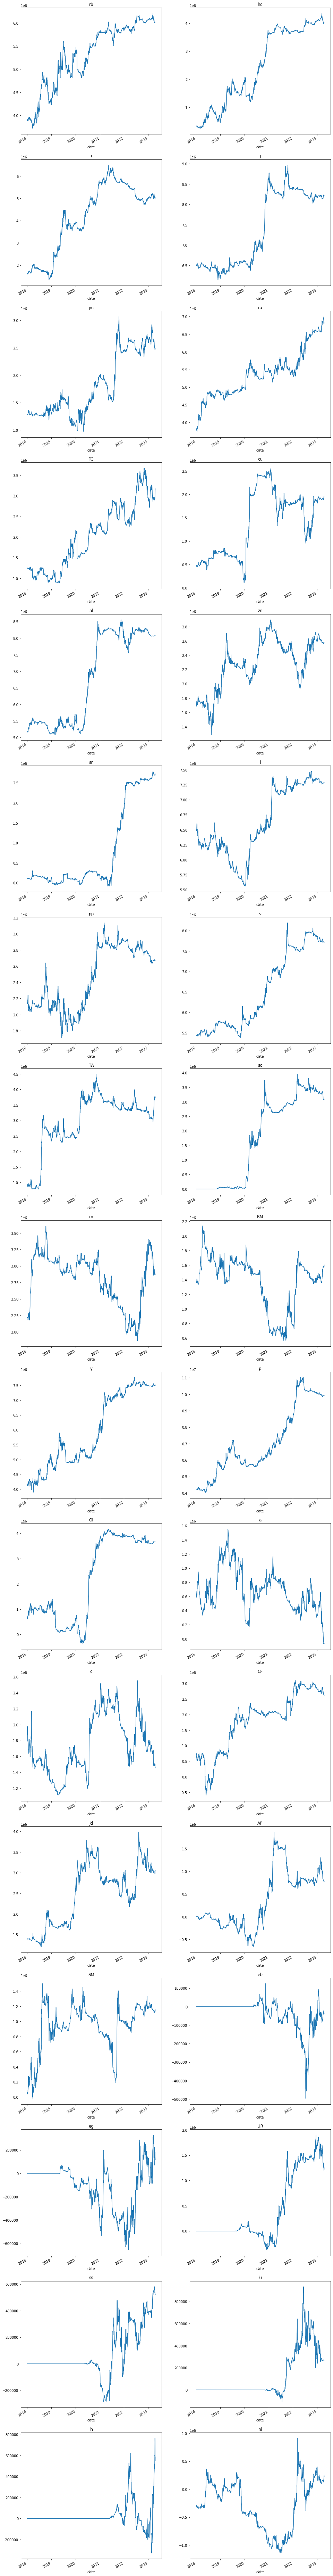

In [19]:
#plot_stats = scen_stats[0]
plot_stats = port_stats
asset_pnl = plot_stats['asset_cumpnl']
asset_stats = plot_stats['asset_sharpe_stats']
plot_start = pd.to_datetime('2018-01-01')

rows = math.ceil(len(product_list)/2)
fig, ax = plt.subplots(rows, 2, figsize=(16, 150))

for i, col in enumerate(asset_pnl.columns):
    row_id = i//2
    col_id = i % 2
    asset_pnl[col][plot_start:].plot(ax = ax[row_id, col_id], title = col)

# print(asset_stats[product_list])
    